In [1]:
import tensorflow
tensorflow.__version__

'2.8.2'

## 1. Import and understanding the data

In [4]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import os
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, Activation, BatchNormalization
from keras.layers import UpSampling2D, Input, Concatenate
from keras.models import Model
from keras.applications import mobilenet_v2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import Recall, Precision
from keras import backend as K
from PIL import Image
from numpy import asarray
from google.colab.patches import cv2_imshow

In [5]:
# set the root folder

path = "/content/drive/MyDrive/Machine Learning/Great Learning/Advanced Computer Vision/ACV Project 1"
os.chdir(path)
!pwd

/content/drive/MyDrive/Machine Learning/Great Learning/Advanced Computer Vision/ACV Project 1


In [6]:
ls

'ACV Project 1.ipynb'  'Part 2 - training images.zip'
'Dataset- Images.npy'   Prediction_Image.jpeg


In [7]:
# import and read images.npy

data = np.load("Dataset- Images.npy", allow_pickle=True)

In [8]:
data.shape

(409, 2)

In [9]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [10]:
data[408][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.5862068965517241}],
  'imageWidth': 656,
  'imageHeight

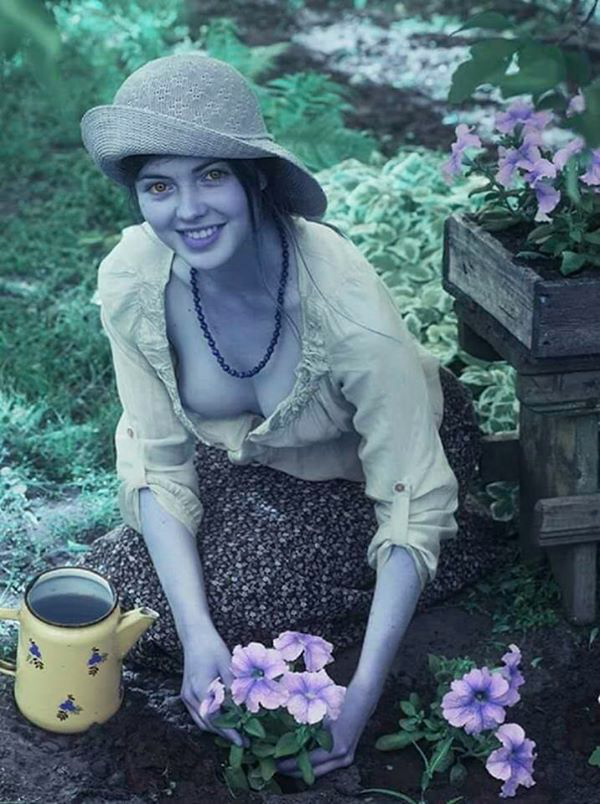

In [11]:
cv2_imshow(data[250][0])

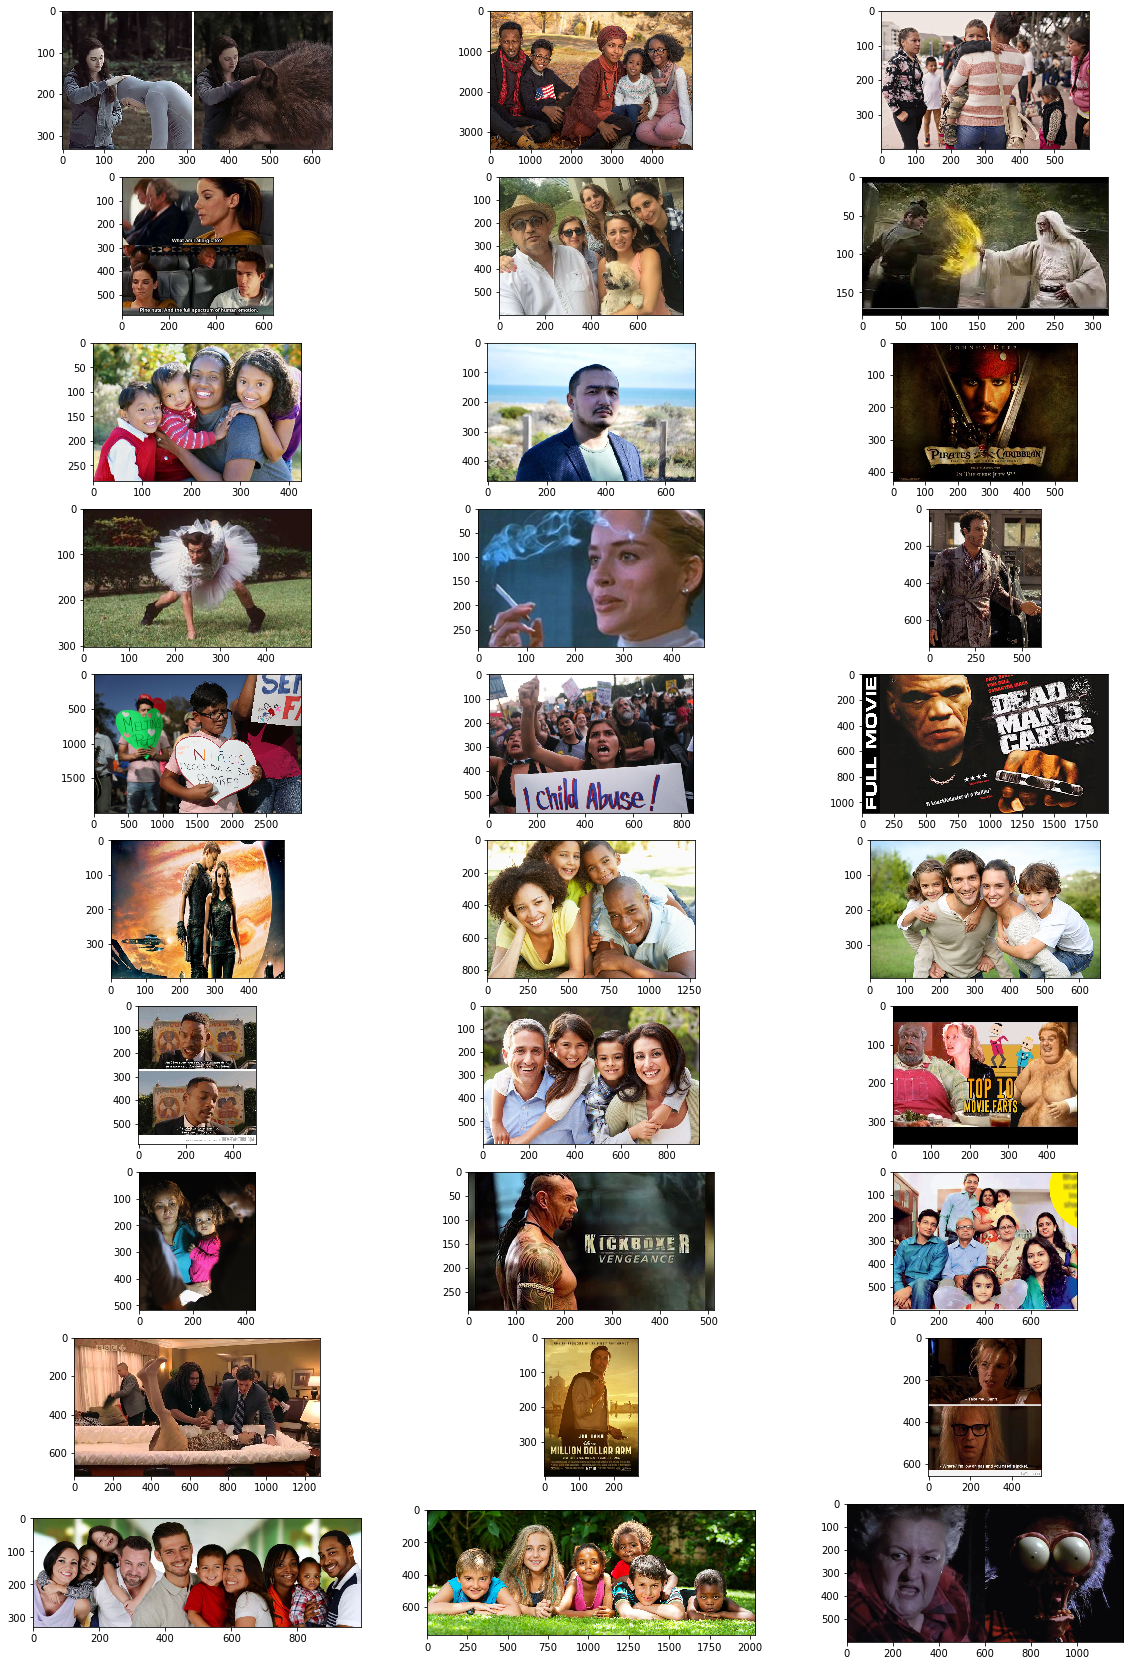

In [12]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

In [13]:
from keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


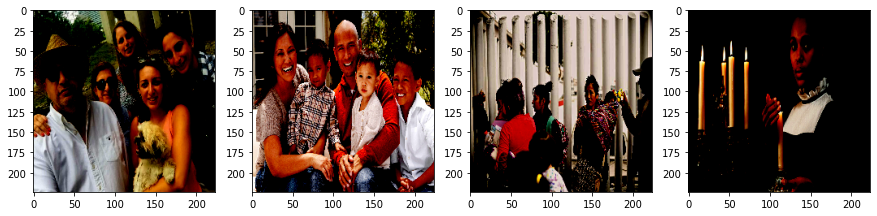

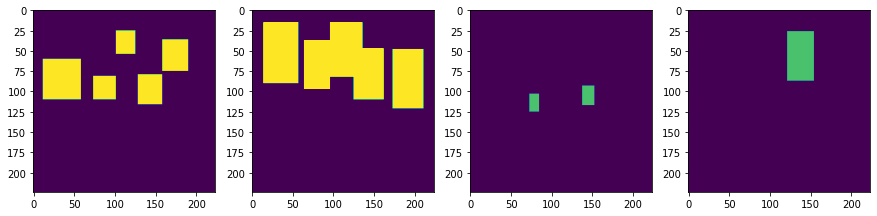

In [15]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

## Model building

In [16]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [19]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = mobilenet_v2.MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [20]:
model = model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [21]:
# design you own dice co-efficient and loss function

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [23]:
# compiling the model

opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [24]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [25]:
# training the model

train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 188s 4s/step - loss: 0.7068 - dice_coef: 0.2937 - recall_1: 0.5765 - precision_1: 0.3432 - val_loss: 0.7666 - val_dice_coef: 0.2509 - val_recall_1: 0.9957 - val_precision_1: 0.1261 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 147s 4s/step - loss: 0.5813 - dice_coef: 0.4186 - recall_1: 0.8593 - precision_1: 0.4638 - val_loss: 0.7250 - val_dice_coef: 0.2936 - val_recall_1: 0.9900 - val_precision_1: 0.1962 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 144s 4s/step - loss: 0.5508 - dice_coef: 0.4489 - recall_1: 0.8765 - precision_1: 0.4883 - val_loss: 0.6825 - val_dice_coef: 0.3379 - val_recall_1: 0.9795 - val_precision_1: 0.2653 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 147s 4s/step - loss: 0.5246 - dice_coef: 0.4752 - recall_1: 0.8922 - precision_1: 0.5146 - val_loss: 0.6658 - val_dice_coef: 0.3555 - val_recall_1: 0.9767 - val_precision_1: 0.2813 - lr: 1.0000e-04


In [26]:
# evaluating the model

test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 2s 490ms/step - loss: 0.4711 - dice_coef: 0.5315 - recall_1: 0.5067 - precision_1: 0.7421


[0.4710654616355896, 0.5315296649932861, 0.506738543510437, 0.7421496510505676]

In [27]:
ls

'ACV Project 1.ipynb'  'Part 2 - training images.zip'
'Dataset- Images.npy'   Prediction_Image.jpeg


In [29]:
filename = './Prediction_Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [30]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [31]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.04056498],
         [0.04803336],
         [0.0482161 ],
         ...,
         [0.04753345],
         [0.04798979],
         [0.0436092 ]],

        [[0.04423887],
         [0.05561635],
         [0.04590747],
         ...,
         [0.03963524],
         [0.04141754],
         [0.04417613]],

        [[0.03736794],
         [0.05257115],
         [0.04111573],
         ...,
         [0.04382041],
         [0.04333022],
         [0.04736283]],

        ...,

        [[0.04516476],
         [0.05012995],
         [0.04129937],
         ...,
         [0.04380727],
         [0.04042089],
         [0.04723123]],

        [[0.04590064],
         [0.0442515 ],
         [0.03616741],
         ...,
         [0.04053769],
         [0.03745475],
         [0.04514357]],

        [[0.04445827],
         [0.05932042],
         [0.04640263],
         ...,
         [0.0499005 ],
         [0.04908144],
         [0.05064458]]]], dtype=float32)

In [32]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

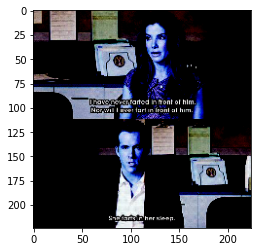

In [34]:
plt.imshow(feat_scaled)

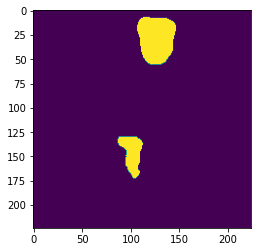

In [35]:
plt.imshow(pred_mask)

# Part 2

In [72]:
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

In [77]:
project_path = '/content/drive/MyDrive/Machine Learning/Great Learning/Advanced Computer Vision/ACV Project 1/'
image_files = 'Part 2 - training images.zip'

In [76]:
ls

'ACV Project 1.ipynb'                 'Part 2 - training images.zip'
'Dataset- Images.npy'                  Prediction_Image.jpeg
 haarcascade_frontalface_default.xml   training_images/


In [78]:
images_zip_path = os.path.join(project_path, image_files)

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [79]:
zip_dir_loc = z.filelist[0].filename.split("/")[0] 
zip_dir_loc

'training_images'

In [80]:
raw_img_file_names = [os.path.join(zip_dir_loc,i) for i in os.listdir(zip_dir_loc)]
raw_img_file_names[:5]

['training_images/REAL_00963.JPG',
 'training_images/REAL_01015.JPG',
 'training_images/REAL_01053.JPG',
 'training_images/REAL_00946.JPG',
 'training_images/REAL_01006.JPG']

In [81]:
img_list = []
for imgs in tqdm(raw_img_file_names):
  tst_img = cv2.imread(imgs)
  img_list.append(tst_img)
img_list = np.array(img_list)
display(Markdown(f"#### {img_list.shape}"))

  0%|          | 0/2182 [00:00<?, ?it/s]

#### (2182, 600, 600, 3)

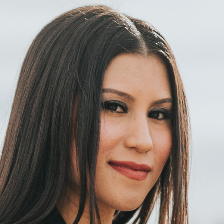

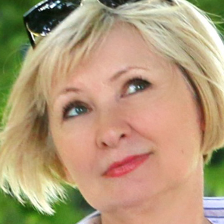

In [82]:
from google.colab.patches import cv2_imshow

for i in img_list[:2,]:
  cv2_imshow(cv2.resize(i,(224,224)))

In [83]:
def test_bb(df,fname,title=""):

  tst_img = cv2.imread(fname)
  temp_df = df[df['Image_Name'] == fname]
  rect_img = []
  for rows in temp_df.index:
    x = df['x'][rows]
    y = df['y'][rows]
    w = df['w'][rows]
    h = df['h'][rows]
    cv2.rectangle(tst_img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(tst_img, title, (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  cv2_imshow(tst_img)
  
  return

In [84]:
def show_face(img_list,scale=1.0):

  for imgs in img_list:
    img = cv2.imread(imgs)
    img_w  = int(img.shape[1]*scale)
    img_h = int(img.shape[0]*scale)
    img = cv2.resize(img,(img_w,img_h))
    display(Markdown(f"#### {imgs}"))
    cv2_imshow(img)

  return

In [85]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-09-16 17:20:45--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2022-09-16 17:20:45 (15.5 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



In [86]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

### Bounding Box parameters are `x`:82, `y`:115, `width`:418, `height`:418

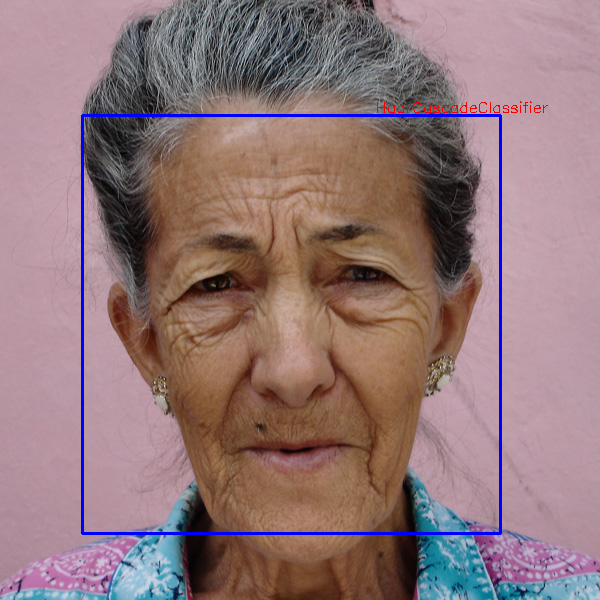

In [87]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

test_img = cv2.imread(raw_img_file_names[10])
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(grey,1.1,4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2.putText(test_img, "HaarCascadeClassifier", (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))

# Display the output
display(Markdown(f"### Bounding Box parameters are `x`:{x}, `y`:{y}, `width`:{w}, `height`:{h}"))
cv2_imshow(test_img)

In [100]:
%%time
haar_undetected_images = []
haar_detected_images = []

for imgs, fnames in tqdm(zip
                         (img_list,raw_img_file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x, 
                  'y':y, 
                  'w':w,
                  'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 1860 images

#### Failed to detect faces for 322 images

CPU times: user 12min 49s, sys: 6.27 s, total: 12min 56s
Wall time: 7min 2s


In [101]:
haar_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     202  176  324  324           1  training_images/REAL_00963.JPG
1      78   96  444  444           1  training_images/REAL_01015.JPG
2      68   50  471  471           1  training_images/REAL_01053.JPG
3      53  120  431  431           1  training_images/REAL_01006.JPG
4      47   72  462  462           1  training_images/REAL_00974.JPG
...   ...  ...  ...  ...         ...                             ...
2017  102  185  405  405           1  training_images/real_00089.jpg
2018  222  204  279  279           1  training_images/real_00036.jpg
2019   91   28   90   90           3  training_images/real_00004.jpg
2020   13   12  162  162           3  training_images/real_00004.jpg
2021  134  173  356  356           3  training_images/real_00004.jpg

[2022 rows x 6 columns]

In [103]:
haar_img_box_df.to_csv('haar_img_box_df.csv')